# Example python-control package

## Dependencies

In [1]:
import os
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np
%matplotlib inline
#import control
from control.matlab import *  # MATLAB-like functions 
#to solve ODE
from scipy import integrate

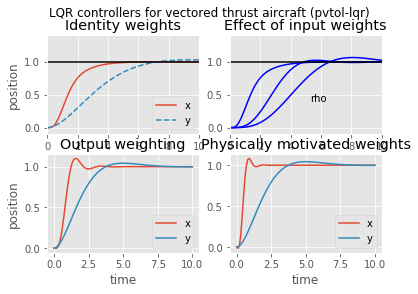

In [2]:
# pvtol_lqr.m - LQR design for vectored thrust aircraft
# RMM, 14 Jan 03
#
# This file works through an LQR based design problem, using the
# planar vertical takeoff and landing (PVTOL) aircraft example from
# Astrom and Murray, Chapter 5.  It is intended to demonstrate the
# basic functionality of the python-control package.
#
#
# System dynamics
#
# These are the dynamics for the PVTOL system, written in state space
# form.
#

# System parameters
m = 4       # mass of aircraft
J = 0.0475  # inertia around pitch axis
r = 0.25    # distance to center of force
g = 9.8     # gravitational constant
c = 0.05    # damping factor (estimated)

# State space dynamics
xe = [0, 0, 0, 0, 0, 0]  # equilibrium point of interest
ue = [0, m*g]  # (note these are lists, not matrices)

# TODO: The following objects need converting from np.matrix to np.array
# This will involve re-working the subsequent equations as the shapes
# See below.

# Dynamics matrix (use matrix type so that * works for multiplication)
A = np.matrix(
    [[0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 1],
     [0, 0, (-ue[0]*np.sin(xe[2]) - ue[1]*np.cos(xe[2]))/m, -c/m, 0, 0],
     [0, 0, (ue[0]*np.cos(xe[2]) - ue[1]*np.sin(xe[2]))/m, 0, -c/m, 0],
     [0, 0, 0, 0, 0, 0]]
)

# Input matrix
B = np.matrix(
    [[0, 0], [0, 0], [0, 0],
     [np.cos(xe[2])/m, -np.sin(xe[2])/m],
     [np.sin(xe[2])/m, np.cos(xe[2])/m],
     [r/J, 0]]
)

# Output matrix 
C = np.matrix([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
D = np.matrix([[0, 0], [0, 0]])

#
# Construct inputs and outputs corresponding to steps in xy position
#
# The vectors xd and yd correspond to the states that are the desired
# equilibrium states for the system.  The matrices Cx and Cy are the 
# corresponding outputs.
#
# The way these vectors are used is to compute the closed loop system
# dynamics as
#
#   xdot = Ax + B u  =>  xdot = (A-BK)x + K xd
#      u = -K(x - xd)       y = Cx
#
# The closed loop dynamics can be simulated using the "step" command, 
# with K*xd as the input vector (assumes that the "input" is unit size,
# so that xd corresponds to the desired steady state.
#

xd = np.matrix([[1], [0], [0], [0], [0], [0]])
yd = np.matrix([[0], [1], [0], [0], [0], [0]])

#
# Extract the relevant dynamics for use with SISO library
#
# The current python-control library only supports SISO transfer
# functions, so we have to modify some parts of the original MATLAB
# code to extract out SISO systems.  To do this, we define the 'lat' and
# 'alt' index vectors to consist of the states that are are relevant
# to the lateral (x) and vertical (y) dynamics.
#

# Indices for the parts of the state that we want
lat = (0, 2, 3, 5)
alt = (1, 4)

# Decoupled dynamics
Ax = (A[lat, :])[:, lat]  # ! not sure why I have to do it this way
Bx = B[lat, 0]
Cx = C[0, lat]
Dx = D[0, 0]

Ay = (A[alt, :])[:, alt]  # ! not sure why I have to do it this way
By = B[alt, 1]
Cy = C[1, alt]
Dy = D[1, 1]

# Label the plot
plt.clf()
plt.suptitle("LQR controllers for vectored thrust aircraft (pvtol-lqr)")

#
# LQR design
#

# Start with a diagonal weighting
Qx1 = np.diag([1, 1, 1, 1, 1, 1])
Qu1a = np.diag([1, 1])
K, X, E = lqr(A, B, Qx1, Qu1a)
K1a = np.matrix(K)

# Close the loop: xdot = Ax - B K (x-xd)
# Note: python-control requires we do this 1 input at a time
# H1a = ss(A-B*K1a, B*K1a*concatenate((xd, yd), axis=1), C, D);
# (T, Y) = step(H1a, T=np.linspace(0,10,100));

# TODO: The following equations will need modifying when converting from np.matrix to np.array
# because the results and even intermediate calculations will be different with numpy arrays
# For example:
# Bx = B[lat, 0]
# Will need to be changed to:
# Bx = B[lat, 0].reshape(-1, 1)
# (if we want it to have the same shape as before)

# For reference, here is a list of the correct shapes of these objects:
# A: (6, 6)
# B: (6, 2)
# C: (2, 6)
# D: (2, 2)
# xd: (6, 1)
# yd: (6, 1)
# Ax: (4, 4)
# Bx: (4, 1)
# Cx: (1, 4)
# Dx: ()
# Ay: (2, 2)
# By: (2, 1)
# Cy: (1, 2)

# Step response for the first input
H1ax = ss(Ax - Bx*K1a[0, lat], Bx*K1a[0, lat]*xd[lat, :], Cx, Dx)
Yx, Tx = step(H1ax, T=np.linspace(0, 10, 100))

# Step response for the second input
H1ay = ss(Ay - By*K1a[1, alt], By*K1a[1, alt]*yd[alt, :], Cy, Dy)
Yy, Ty = step(H1ay, T=np.linspace(0, 10, 100))

plt.subplot(221)
plt.title("Identity weights")
# plt.plot(T, Y[:,1, 1], '-', T, Y[:,2, 2], '--')
plt.plot(Tx.T, Yx.T, '-', Ty.T, Yy.T, '--')
plt.plot([0, 10], [1, 1], 'k-')

plt.axis([0, 10, -0.1, 1.4])
plt.ylabel('position')
plt.legend(('x', 'y'), loc='lower right')

# Look at different input weightings
Qu1a = np.diag([1, 1])
K1a, X, E = lqr(A, B, Qx1, Qu1a)
H1ax = ss(Ax - Bx*K1a[0, lat], Bx*K1a[0, lat]*xd[lat, :], Cx, Dx)

Qu1b = (40 ** 2)*np.diag([1, 1])
K1b, X, E = lqr(A, B, Qx1, Qu1b)
H1bx = ss(Ax - Bx*K1b[0, lat], Bx*K1b[0, lat]*xd[lat, :], Cx, Dx)

Qu1c = (200 ** 2)*np.diag([1, 1])
K1c, X, E = lqr(A, B, Qx1, Qu1c)
H1cx = ss(Ax - Bx*K1c[0, lat], Bx*K1c[0, lat]*xd[lat, :], Cx, Dx)

[Y1, T1] = step(H1ax, T=np.linspace(0, 10, 100))
[Y2, T2] = step(H1bx, T=np.linspace(0, 10, 100))
[Y3, T3] = step(H1cx, T=np.linspace(0, 10, 100))

plt.subplot(222)
plt.title("Effect of input weights")
plt.plot(T1.T, Y1.T, 'b-')
plt.plot(T2.T, Y2.T, 'b-')
plt.plot(T3.T, Y3.T, 'b-')
plt.plot([0, 10], [1, 1], 'k-')

plt.axis([0, 10, -0.1, 1.4])

# arcarrow([1.3, 0.8], [5, 0.45], -6)
plt.text(5.3, 0.4, 'rho')

# Output weighting - change Qx to use outputs
Qx2 = C.T*C
Qu2 = 0.1*np.diag([1, 1])
K, X, E = lqr(A, B, Qx2, Qu2)
K2 = np.matrix(K)

H2x = ss(Ax - Bx*K2[0, lat], Bx*K2[0, lat]*xd[lat, :], Cx, Dx)
H2y = ss(Ay - By*K2[1, alt], By*K2[1, alt]*yd[alt, :], Cy, Dy)

plt.subplot(223)
plt.title("Output weighting")
[Y2x, T2x] = step(H2x, T=np.linspace(0, 10, 100))
[Y2y, T2y] = step(H2y, T=np.linspace(0, 10, 100))
plt.plot(T2x.T, Y2x.T, T2y.T, Y2y.T)
plt.ylabel('position')
plt.xlabel('time')
plt.ylabel('position')
plt.legend(('x', 'y'), loc='lower right')

#
# Physically motivated weighting
#
# Shoot for 1 cm error in x, 10 cm error in y.  Try to keep the angle
# less than 5 degrees in making the adjustments.  Penalize side forces
# due to loss in efficiency.
#

Qx3 = np.diag([100, 10, 2*np.pi/5, 0, 0, 0])
Qu3 = 0.1*np.diag([1, 10])


(K, X, E) = lqr(A, B, Qx3, Qu3)
K3 = np.matrix(K)

H3x = ss(Ax - Bx*K3[0, lat], Bx*K3[0, lat]*xd[lat, :], Cx, Dx)
H3y = ss(Ay - By*K3[1, alt], By*K3[1, alt]*yd[alt, :], Cy, Dy)
plt.subplot(224)
# step(H3x, H3y, 10)
[Y3x, T3x] = step(H3x, T=np.linspace(0, 10, 100))
[Y3y, T3y] = step(H3y, T=np.linspace(0, 10, 100))
plt.plot(T3x.T, Y3x.T, T3y.T, Y3y.T)
plt.title("Physically motivated weights")
plt.xlabel('time')
plt.legend(('x', 'y'), loc='lower right')

if 'PYCONTROL_TEST_EXAMPLES' not in os.environ:
    plt.show()